# **SAE 5.03 : Mise en œuvre d’un processus de Datamining** 
## **Sujet : Analyse des commentaires des utilisateurs et prédiction de la satisfaction des utilisateurs**
### *Date :  30/12/2024-15/01/2025*
### *Promo : BUT SD3*
### *Auteur : Julien RENOULT*

# Introduction sur le sujet

Cette SAE consiste dans un premier temps à faire une segmentation des différents commentaires des utilisateurs et ensuite d'utiliser le Deep Learning pour prédire la satisfaction de l'utilisateur selon son commentaire. Pour ce faire, nous allons récupérer les données conservées dans MongoDB avec la collection *olist_order_reviews_dataset* dans la base ***olist***. A la suite, nous ferons une préparation des données nécessaires (traitement de langage naturel) pour finir avec la segmentation et le Deep Learning.

In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pymongo import MongoClient
# Ne garder que les mots portugais
from spellchecker import SpellChecker
# Tokeniser les mots pour faire la lemmatissation
from nltk.tokenize import word_tokenize
# Téléchargement du modèle portugais pour lemmatisser (30 secondes environ)
import spacy

# Fixer l'aléatoire
seed = 22

# Fixer l'aléatoire le traitement des données et la création des modèles
spacy.util.fix_random_seed(seed)

# Télécharger les ressources nécessaires si ce n'est pas encore fait
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1ère partie : importation des données (MongoDB)

## Connexion à la base de données

In [2]:
# Instance de connexion de la BDD (à changer si nécessaire)
client = MongoClient("mongodb://localhost:27017") # Connexion
nom_db = "olist" # Nom de la base de données MongoDB
collection = "olist_order_reviews_dataset" # Nom de la collection

In [3]:
# Vérification du succès de l'opération
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [4]:
# Sélection du database
db = client[nom_db]

In [5]:
# Vérification du succès de l'opération
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'olist')

Les données qui nous intéresse sont dans la collection *olist_order_reviews_dataset*.

In [6]:
coll_rev = db[collection]

In [7]:
# Vérification du succès de l'opération
coll_rev

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'olist'), 'olist_order_reviews_dataset')

## Extraction des données de la base
On va extraire les reviews qui contiennent bien sûr un commentaire et une note.

In [8]:
# Création d'une fct utilitaire pour récupérer/montrer les résultats du cursor
def print_cursor(cursor, aff=True):
    """
    Fonction : permet de montrer les résultats d'un curseur après exécution d'une requête de type MongoDB (pymongo)

    Argument :
    - cursor : le curseur en question à parcourir

    Retour :
    retourne une liste des résultats du cursor et les affiche aussi
    """

    liste_cursor = []
    for res in cursor:
        if aff :
            print(res)
        liste_cursor.append(res)
    return liste_cursor

In [9]:
cursor = coll_rev.find({ "$and" :
        [{"review_comment_message" : { "$ne": None }},
         {"review_score" : { "$ne": None }}]
    })

In [10]:
# Récupération des résultats sous forme de liste
liste_cursor = print_cursor(cursor, False)

# Fermeture de la connexion de MongoDB
client.close()

In [11]:
# Transformation en DataFrame
dataset = pd.DataFrame(liste_cursor)

In [12]:
# Vérification du succès de l'opération
dataset.head()

_id                         review_id  \
0  6772dd8aa314f18a2c84a7c7  e64fb393e7b32834bb789ff8bb30750e   
1  6772dd8aa314f18a2c84a7c8  f7c4243c7fe1938f181bec41a392bdeb   
2  6772dd8aa314f18a2c84a7cd  8670d52e15e00043ae7de4c01cc2fe06   
3  6772dd8aa314f18a2c84a7d0  4b49719c8a200003f700d3d986ea1a19   
4  6772dd8aa314f18a2c84a7d3  3948b09f7c818e2d86c9a546758b2335   

                           order_id  review_score review_comment_title  \
0  658677c97b385a9be170737859d3511b             5                 None   
1  8e6bfb81e283fa7e4f11123a3fb894f1             5                 None   
2  b9bf720beb4ab3728760088589c62129             4            recomendo   
3  9d6f15f95d01e79bd1349cc208361f09             4                 None   
4  e51478e7e277a83743b6f9991dbfa3fb             5      Super recomendo   

                              review_comment_message review_creation_date  \
0              Recebi bem antes do prazo estipulado.           2017-04-21   
1  Parabéns lojas lannister adorei comprar pela I...           2018-03-01   
2  aparelho eficiente. no site a marca do aparelh...           2018-05-22   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n           2018-02-16   
4  Vendedor confiável, produto ok e entrega antes...           2018-05-23   

  review_answer_timestamp  
0     2017-04-21 22:02:06  
1     2018-03-02 10:26:53  
2     2018-05-23 16:45:47  
3     2018-02-20 10:52:22  
4     2018-05-24 03:00:01

In [13]:
# Les dimensions de notre extraction
dataset.shape

(40977, 8)

In [14]:
# Les colonnes et leurs types
dataset.dtypes

_id                                object
review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object

#### Commentaire :
L'importation s'est bien passée, maintenant nous allons sélectionner les colonnes d'intérêts qui sont :
- review_id
- review_score
- review_comment_message


In [15]:
# Sélection des colonnes
data = dataset[["review_id", "review_score", "review_comment_message"]]

In [16]:
# Véirifcation du succès de l'opération
data.head(20)

review_id  review_score  \
0   e64fb393e7b32834bb789ff8bb30750e             5   
1   f7c4243c7fe1938f181bec41a392bdeb             5   
2   8670d52e15e00043ae7de4c01cc2fe06             4   
3   4b49719c8a200003f700d3d986ea1a19             4   
4   3948b09f7c818e2d86c9a546758b2335             5   
5   9314d6f9799f5bfba510cc7bcd468c01             2   
6   373cbeecea8286a2b66c97b1b157ec46             1   
7   d21bbc789670eab777d27372ab9094cc             5   
8   0e0190b9db53b689b285d3f3916f8441             5   
9   fe3db7c069d694bab50cc43463f91608             5   
10  e07eee7ad7666276bd8b27fbd83fd1ff             5   
11  2c5e27fc178bde7ac173c9c62c31b070             1   
12  58044bca115705a48fe0e00a21390c54             1   
13  c92cdd7dd544a01aa35137f901669cdf             4   
14  08c9d79ec0eba1d252e3f52f14b8e6a9             5   
15  2170c9452c2216457b36003fe2969fbb             5   
16  b193ff3c9f32a01f3a0d9ae26b94d244             5   
17  9fd59cd04b42f600df9f25e54082a8d1             1   
18  86c5cfa7fcbde303f704b60a78ced7d6             5   
19  890ec1767be8eb104877db6d68eaade5             5   

                               review_comment_message  
0               Recebi bem antes do prazo estipulado.  
1   Parabéns lojas lannister adorei comprar pela I...  
2   aparelho eficiente. no site a marca do aparelh...  
3     Mas um pouco ,travando...pelo valor ta Boa.\r\n  
4   Vendedor confiável, produto ok e entrega antes...  
5   GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...  
6                                             Péssimo  
7                                        Loja nota 10  
8               obrigado pela atençao amim dispensada  
9   A compra foi realizada facilmente.\r\nA entreg...  
10                     relógio muito bonito e barato.  
11                Não gostei ! Comprei gato por lebre  
12  Sempre compro pela Internet e a entrega ocorre...  
13  Recebi exatamente o que esperava. As demais en...  
14                                        Recomendo ,  
15                                         muito boa   
16  Tô completamente apaixonada, loja super respon...  
17                       Nada de chegar o meu pedido.  
18                         Muito bom. muito cheiroso.  
19  otimo vendedor chegou ate antes do prazo , ado...

In [17]:
data.duplicated().any() # Présence de doublons dans les avis

np.True_

In [18]:
# Regardons les doublons en question
data[data.duplicated()]

review_id  review_score  \
1399   3242cc306a9218d0377831e175d62fbf             5   
2384   308316408775d1600dad81bd3184556d             5   
3009   8ee90ac383cf825bb7f4756130d4e74a             5   
3751   03a6a25db577d0689440933055111897             5   
3906   7168439a7228c5684a494116c1c8da5f             5   
...                                 ...           ...   
40736  289450935cf7a082af13e04160716ce5             5   
40835  63c51abb0488ed1346fe3215f1571f15             1   
40934  2c6c08892b83ba4c1be33037c2842294             4   
40941  6ec93e77f444e0b1703740a69122e35d             5   
40958  2afe63a67dfd99b3038f568fb47ee761             5   

                                  review_comment_message  
1399                                              Ótimo   
2384   Ajudem a rastrear uma das 3 prateleiras que fa...  
3009                                           recomendo  
3751   Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...  
3906      embalagem apropriada, entregue dentro do prazo  
...                                                  ...  
40736                 produto chegou correto , recomendo  
40835  RECEBI SOMENTE UMA MAQUINA DE MOER CARNE SENDO...  
40934  Chegou um pouco amassada, mas nada de mais, e ...  
40941              Vendedor compromisso do vou o cliente  
40958  Muito bom, produto conforme anunciado, entrega...  

[309 rows x 3 columns]

#### Commentaire :
Les doublons existent car les avis peuvent concerner plusieurs commandes ce qui amène à multiplier une ou plusieurs même ligne dû au lien de la commande (order_id). On va donc garder que le premier et supprimer les doublons pour faciliter l'analyse.

In [19]:
# Supprimer doublons
data.drop_duplicates(subset="review_id", keep="first", inplace=True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_10560\1851309639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset="review_id", keep="first", inplace=True)


In [20]:
# Regardons maintenant les dimensions de notre dataframe
data.shape

(40668, 3)

In [21]:
# Vérification s'il n'y a pas la présence de valeurs manquantes
percent_nan = (data.isna().sum() / len(data)) * 100

In [22]:
# Observations de valeurs manquantes
percent_nan # Pas de valeurs manquantes du aux conditions données.

review_id                 0.0
review_score              0.0
review_comment_message    0.0
dtype: float64

# **2ème partie : préparation des données**

Maintenant que nous avons importé les données, nous allons préparer ces données en transformant notre variable *review_score* en une variable catégorique et faire le NLP sur les commentaires (*review_comment_message*).

### Transformation de la variable numérique en une variable catégorique

In [23]:
# Création de la fonction permettant la transformation numérique en catégorique
def transf_cat(row):
    """
    Fonction : transformation de la variable score en une variable 
    catégorique classée selon sa valeur
    
    Argument : 
    - row : ligne concernée dont on fait la transformation

    Retour : retourne la catégorie de satisfaction
    """

    # Initialisation des variables
    score = row["review_score"]
    satis = ""

    # Utilisation du match/case
    match score:
        case score if score <= 1.5:
            satis = "mécontent"
        case score if score < 2.5 :
            satis = "insatisfait"
        case score if score <= 3.5 :
            satis = "satisfait"
        case _:
            satis = "très satisfait"

    return satis

In [24]:
# Application de la transformation
data["target"] = data.apply(transf_cat, axis=1) # axis = 1, sur les lignes

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_10560\2532775192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target"] = data.apply(transf_cat, axis=1) # axis = 1, sur les lignes


In [25]:
# Vérification du succès de l'opération
data.head(20)

review_id  review_score  \
0   e64fb393e7b32834bb789ff8bb30750e             5   
1   f7c4243c7fe1938f181bec41a392bdeb             5   
2   8670d52e15e00043ae7de4c01cc2fe06             4   
3   4b49719c8a200003f700d3d986ea1a19             4   
4   3948b09f7c818e2d86c9a546758b2335             5   
5   9314d6f9799f5bfba510cc7bcd468c01             2   
6   373cbeecea8286a2b66c97b1b157ec46             1   
7   d21bbc789670eab777d27372ab9094cc             5   
8   0e0190b9db53b689b285d3f3916f8441             5   
9   fe3db7c069d694bab50cc43463f91608             5   
10  e07eee7ad7666276bd8b27fbd83fd1ff             5   
11  2c5e27fc178bde7ac173c9c62c31b070             1   
12  58044bca115705a48fe0e00a21390c54             1   
13  c92cdd7dd544a01aa35137f901669cdf             4   
14  08c9d79ec0eba1d252e3f52f14b8e6a9             5   
15  2170c9452c2216457b36003fe2969fbb             5   
16  b193ff3c9f32a01f3a0d9ae26b94d244             5   
17  9fd59cd04b42f600df9f25e54082a8d1             1   
18  86c5cfa7fcbde303f704b60a78ced7d6             5   
19  890ec1767be8eb104877db6d68eaade5             5   

                               review_comment_message          target  
0               Recebi bem antes do prazo estipulado.  très satisfait  
1   Parabéns lojas lannister adorei comprar pela I...  très satisfait  
2   aparelho eficiente. no site a marca do aparelh...  très satisfait  
3     Mas um pouco ,travando...pelo valor ta Boa.\r\n  très satisfait  
4   Vendedor confiável, produto ok e entrega antes...  très satisfait  
5   GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...     insatisfait  
6                                             Péssimo       mécontent  
7                                        Loja nota 10  très satisfait  
8               obrigado pela atençao amim dispensada  très satisfait  
9   A compra foi realizada facilmente.\r\nA entreg...  très satisfait  
10                     relógio muito bonito e barato.  très satisfait  
11                Não gostei ! Comprei gato por lebre       mécontent  
12  Sempre compro pela Internet e a entrega ocorre...       mécontent  
13  Recebi exatamente o que esperava. As demais en...  très satisfait  
14                                        Recomendo ,  très satisfait  
15                                         muito boa   très satisfait  
16  Tô completamente apaixonada, loja super respon...  très satisfait  
17                       Nada de chegar o meu pedido.       mécontent  
18                         Muito bom. muito cheiroso.  très satisfait  
19  otimo vendedor chegou ate antes do prazo , ado...  très satisfait

In [26]:
# Regardons la proportion selon la variable target
satisfaction = round(data["target"].value_counts(normalize=True) * 100, 2)

In [27]:
# Vérification du succès de l'opération
satisfaction

target
très satisfait    64.87
mécontent         21.25
satisfait          8.68
insatisfait        5.21
Name: proportion, dtype: float64

## Observation graphique de nos deux variables

In [28]:
# Création de la fonction d'observation des targets
def distrib_target(df, var, titre, ylabel, xlabel="Pourcentage"):
    """
    Fonction : calcul de la répartition en pourcentage selon une variable + retour graphique

    Arguments :
    - df : le dataframe en question
    - var : nom de la variable à calculer
    - titre : titre principale du graphique
    - ylabel : titre de l'axe y
    - xlabel : titre de l'axe x

    Retour :
    - tableau en DataFrame contenant les valeurs et d'un visuel graphique
    """

    # Calcul en pourcentage de la répartition
    tableau = round(df[var].value_counts(normalize=True) * 100, 2)

    # Transformation en DataFrame
    tableau_df = pd.DataFrame({
        'target' : tableau.index,
        "values" : tableau.values
    })

    # Visuel graphique
    plt.figure(figsize=(10, 6))
    sns.barplot(y='target', x="values", data=tableau_df, palette="Set2")
    plt.title(titre)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    return tableau_df



In [29]:
# Création de la fonction d'observation du nombre de mots
def cpt_mots(df, var, titre, avec_creation = True, var_cpt = "long_coms"):
    """
    Fonction : création du visuel graphique sur le nombre de mots dans les commentaires

    Arguments :
    - df : dataframe contenant la variable en question
    - var : nom de la variable des commentaires
    - titre : titre du graphique
    - avec_creation : valeur booléenne si on doit créer ou non la colonne correspondante

    Retour : 
    - df : dataframe donné par l'utilisateur avec la longueur des commentaires ajoutée
    - visuel graphique sur le nombre de mots
    """

    # Regarder le nombre de mot dans les commentaires
    if avec_creation :
        df[var_cpt] = df[var].apply(lambda x: len(x.split()))

    # Visuel graphique
    sns.displot(df[var_cpt])
    plt.title(titre)
    plt.ylabel("Effectif")
    plt.xlabel("Nombre de mots")
    plt.show()

    # Pour observer les indicateur numériques
    print(df[var_cpt].describe())
    
    # Retourne la variable concernée et le résultat dans le dataframe
    return df

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_10560\10315404.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='target', x="values", data=tableau_df, palette="Set2")


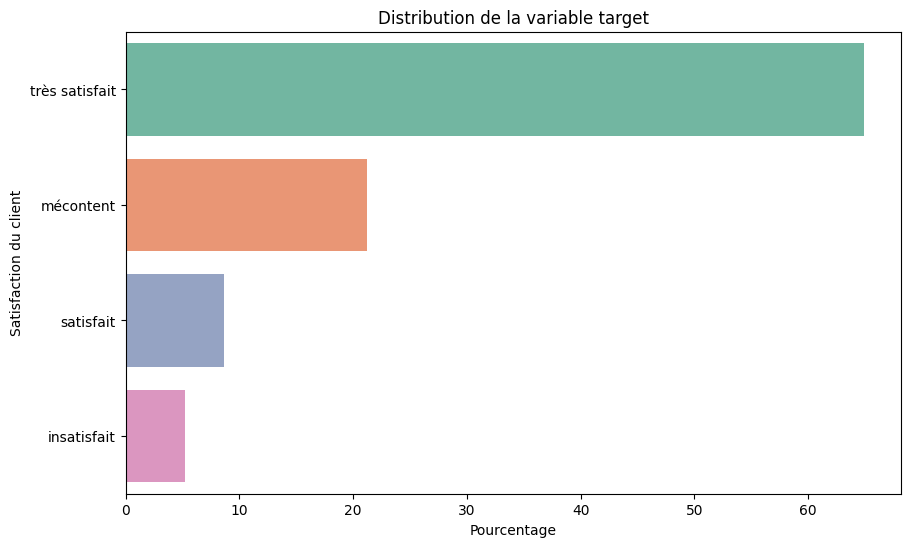

In [30]:
df = distrib_target(data, "target", "Distribution de la variable target", "Satisfaction du client")

#### Commentaire :
On peut observer que dans nos 40 668 avis, on a une très grande majorité de très satisfait avec plus 60% contre moins de 30% pour les mécontents. Les clients satisfaits et insatisfaits sont très peu présents dans ce jeu de données avec moins de 10% chacune (8,68% et 5,21%).

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_10560\409883918.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var_cpt] = df[var].apply(lambda x: len(x.split()))


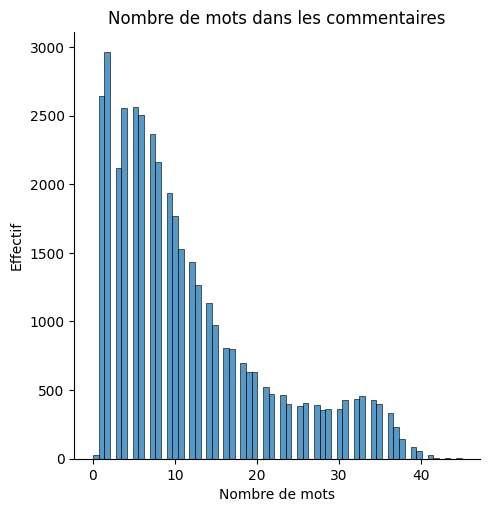

count    40668.000000
mean        11.672421
std          9.548733
min          0.000000
25%          4.000000
50%          9.000000
75%         16.000000
max         45.000000
Name: long_coms, dtype: float64


In [31]:
data = cpt_mots(data, "review_comment_message", "Nombre de mots dans les commentaires")

#### Commentaire :
Nos indicateurs numériques nous montre que les commentaires de nos clients sont entre 0 et 45 mots incluses. On observe que pour plus de 75% des avis ont un nombre de mots inférieurs à 16. Cela montre la très grande présence de commentaire faisant moins de 20 mots. 

**On va supprimer ceux qui ont 0 caractères car ils n'ont pas d'informations du coup sur la satisfaction du client.**

In [32]:
# Observation ce ceux qui ont 0 caractères 
data[data["long_coms"] < 1].shape

(27, 5)

In [33]:
# Filtrage sur la longueur des commentaires
data_nlp = data[data["long_coms"] > 0]

In [34]:
# Vérification du succès de l'opération
data_nlp["long_coms"].describe()

count    40641.000000
mean        11.680175
std          9.547162
min          1.000000
25%          4.000000
50%          9.000000
75%         16.000000
max         45.000000
Name: long_coms, dtype: float64

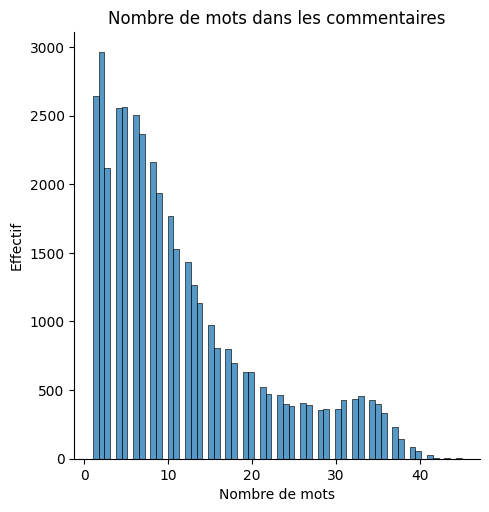

count    40641.000000
mean        11.680175
std          9.547162
min          1.000000
25%          4.000000
50%          9.000000
75%         16.000000
max         45.000000
Name: long_coms, dtype: float64


review_id  review_score  \
0      e64fb393e7b32834bb789ff8bb30750e             5   
1      f7c4243c7fe1938f181bec41a392bdeb             5   
2      8670d52e15e00043ae7de4c01cc2fe06             4   
3      4b49719c8a200003f700d3d986ea1a19             4   
4      3948b09f7c818e2d86c9a546758b2335             5   
...                                 ...           ...   
40972  98fffa80dc9acbde7388bef1600f3b15             4   
40973  df5fae90e85354241d5d64a8955b2b09             5   
40974  a709d176f59bc3af77f4149c96bae357             3   
40975  b3de70c89b1510c4cd3d0649fd302472             5   
40976  efe49f1d6f951dd88b51e6ccd4cc548f             1   

                                  review_comment_message          target  \
0                  Recebi bem antes do prazo estipulado.  très satisfait   
1      Parabéns lojas lannister adorei comprar pela I...  très satisfait   
2      aparelho eficiente. no site a marca do aparelh...  très satisfait   
3        Mas um pouco ,travando...pelo valor ta Boa.\r\n  très satisfait   
4      Vendedor confiável, produto ok e entrega antes...  très satisfait   
...                                                  ...             ...   
40972  para este produto recebi de acordo com a compr...  très satisfait   
40973  Entregou dentro do prazo. O produto chegou em ...  très satisfait   
40974  O produto não foi enviado com NF, não existe v...       satisfait   
40975  Excelente mochila, entrega super rápida. Super...  très satisfait   
40976  meu produto chegou e ja tenho que devolver, po...       mécontent   

       long_coms  
0              6  
1             15  
2             30  
3              7  
4              9  
...          ...  
40972         10  
40973         13  
40974         25  
40975          9  
40976         16  

[40641 rows x 5 columns]

In [35]:
# Observation à nouveau du graphique
cpt_mots(data_nlp, "", "Nombre de mots dans les commentaires", False)

In [36]:
# Sélection des colonnes en questions
data_nlp = data_nlp.drop(["review_id", "review_score", "long_coms"], axis=1)

In [37]:
data_nlp.columns

Index(['review_comment_message', 'target'], dtype='object')

**Maintenant que nous avons enlevé les commentaires qui ne contiennent pas de texte, nous pouvons faire le traitement NLP**.

## Traitement de langage naturel sur les commentaires (NLP)

### Mettre en minuscules tous les caractères

In [38]:
# Convertir les capitals en lettres minuscules
data_nlp["review_comment_message_low"] = data_nlp["review_comment_message"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [39]:
# Vérification du succès de l'opération
data_nlp.head()

review_comment_message          target  \
0              Recebi bem antes do prazo estipulado.  très satisfait   
1  Parabéns lojas lannister adorei comprar pela I...  très satisfait   
2  aparelho eficiente. no site a marca do aparelh...  très satisfait   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n  très satisfait   
4  Vendedor confiável, produto ok e entrega antes...  très satisfait   

                          review_comment_message_low  
0              recebi bem antes do prazo estipulado.  
1  parabéns lojas lannister adorei comprar pela i...  
2  aparelho eficiente. no site a marca do aparelh...  
3        mas um pouco ,travando...pelo valor ta boa.  
4  vendedor confiável, produto ok e entrega antes...

### Enlever les nombres de nos commentaires

Pour éviter d'avoir des problèmes au niveau des nombres qui n'apportent souvent pas trop d'informations, on va les supprimer de nos commentaires pour donner une meilleure qualité de nos données.

In [40]:
# Utilisation du regex pour supprimer les nombres qui sont suivies de caractères alphabétiques ou non
# Par exemple : "27cm", "200" sont à supprimer
data_nlp['review_com_sans_nb'] = data_nlp['review_comment_message_low'].str.replace(r'\b\w*\d+\w*\b', '', regex=True)

In [41]:
# Vérification du succès de l'opération
data_nlp.head()

review_comment_message          target  \
0              Recebi bem antes do prazo estipulado.  très satisfait   
1  Parabéns lojas lannister adorei comprar pela I...  très satisfait   
2  aparelho eficiente. no site a marca do aparelh...  très satisfait   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n  très satisfait   
4  Vendedor confiável, produto ok e entrega antes...  très satisfait   

                          review_comment_message_low  \
0              recebi bem antes do prazo estipulado.   
1  parabéns lojas lannister adorei comprar pela i...   
2  aparelho eficiente. no site a marca do aparelh...   
3        mas um pouco ,travando...pelo valor ta boa.   
4  vendedor confiável, produto ok e entrega antes...   

                                  review_com_sans_nb  
0              recebi bem antes do prazo estipulado.  
1  parabéns lojas lannister adorei comprar pela i...  
2  aparelho eficiente. no site a marca do aparelh...  
3        mas um pouco ,travando...pelo valor ta boa.  
4  vendedor confiável, produto ok e entrega antes...

In [42]:
# Vérifions la non présence de nombre
data_nlp["contient_nb"] = data_nlp["review_com_sans_nb"].str.match(r'.*\d.*')

In [43]:
# On peut observer qu'il n'y a aucun commentaire qui ne contient des caractères numériques
data_nlp[data_nlp["contient_nb"] == True]

Empty DataFrame
Columns: [review_comment_message, target, review_comment_message_low, review_com_sans_nb, contient_nb]
Index: []

In [44]:
# Sélection des colonnes d'intérêts
data_nlp = data_nlp[["target", "review_com_sans_nb"]]

In [45]:
# Vérification du succès de l'opération
data_nlp.head()

target                                 review_com_sans_nb
0  très satisfait              recebi bem antes do prazo estipulado.
1  très satisfait  parabéns lojas lannister adorei comprar pela i...
2  très satisfait  aparelho eficiente. no site a marca do aparelh...
3  très satisfait        mas um pouco ,travando...pelo valor ta boa.
4  très satisfait  vendedor confiável, produto ok e entrega antes...

### Enlever les ponctuations + caractères spéciaux + sous-chaînes répétitives

In [46]:
# Enlever les ponctuations + caractère spéciaux ("_", "$")
data_nlp["review_comment_message_word"] = data_nlp["review_com_sans_nb"].str.replace('[^\w\s]|_', "", regex=True)

In [47]:
# Vérification du succès de l'opération
data_nlp.head()

target                                 review_com_sans_nb  \
0  très satisfait              recebi bem antes do prazo estipulado.   
1  très satisfait  parabéns lojas lannister adorei comprar pela i...   
2  très satisfait  aparelho eficiente. no site a marca do aparelh...   
3  très satisfait        mas um pouco ,travando...pelo valor ta boa.   
4  très satisfait  vendedor confiável, produto ok e entrega antes...   

                         review_comment_message_word  
0               recebi bem antes do prazo estipulado  
1  parabéns lojas lannister adorei comprar pela i...  
2  aparelho eficiente no site a marca do aparelho...  
3             mas um pouco travandopelo valor ta boa  
4  vendedor confiável produto ok e entrega antes ...

In [48]:
data_nlp["review_comment_message_word"].str.match(r"[^\w\s]|_", "").any()

np.False_

In [49]:
# Enlever sous-chaînes répétitives (Exemple : "aaaaa", "bbbbb", etc)
data_nlp["review_comment_message_word"] = data_nlp["review_comment_message_word"].str.replace(r"\b(.)\1+\b", '', regex=True)


In [50]:
# Réduire les mots où la présence d'un caractère est trop répétitives (Exemple : porcariaaaaa, nosssaaaaaaa => porcaria, nosa) (minimum 3 fois)
data_nlp["review_comment_message_word"] = data_nlp["review_comment_message_word"].str.replace(r"(.)\1{2,}", r'\1', regex=True)

In [51]:
# Vérification du succès de l'opération
data_nlp[data_nlp["review_comment_message_word"].str.contains("aaaaa")]

Empty DataFrame
Columns: [target, review_com_sans_nb, review_comment_message_word]
Index: []

### Transformations des contractions portugaises en mots entier

In [52]:
# Fonction pour remplacer les contractions
def expand_contractions_nltk(row):

    # Contractions portugaises
    contractions = {
        "à": "a a",
        "às": "a as",
        "ao": "a o",
        "aos": "a os",
        "do": "de o",
        "da": "de a",
        "dos": "de os",
        "das": "de as",
        "dum": "de um",
        "duma": "de uma",
        "duns": "de uns",
        "dumas": "de umas",
        "no": "em o",
        "na": "em a",
        "nos": "em os",
        "nas": "em as",
        "num": "em um",
        "numa": "em uma",
        "nuns": "em uns",
        "numas": "em umas",
        "pelo": "por o",
        "pela": "por a",
        "pelos": "por os",
        "pelas": "por as",
        "àquele": "a aquele",
        "àquela": "a aquela",
        "àqueles": "a aqueles",
        "àquelas": "a aquelas",
        "daquele": "de aquele",
        "daquela": "de aquela",
        "daqueles": "de aqueles",
        "daquelas": "de aquelas",
        "disso": "de isso",
        "disto": "de isto",
        "daquilo": "de aquilo",
        "naquele": "em aquele",
        "naquela": "em aquela",
        "naqueles": "em aqueles",
        "naquelas": "em aquelas",
        "nisso": "em isso",
        "nisto": "em isto",
        "naquilo": "em aquilo",
        "pro": "para o",
        "pra": "para a",
        "pros": "para os",
        "pras": "para as"
    }

    # Tokenize le texte
    tokens = nltk.tokenize.word_tokenize(row["review_comment_message_word"], language='portuguese')
    
    # Remplace les mots contractés par leurs formes complètes
    expanded_tokens = [contractions[word] if word in contractions else word for word in tokens]

    # Recrée la phrase
    return " ".join(expanded_tokens)

In [53]:
# Gestion des contractions
data_nlp["review_comment_message_contractions"] = data_nlp.apply(expand_contractions_nltk, axis=1)

In [54]:
# Vérification du succès de l'opération
data_nlp.head(10)

target                                 review_com_sans_nb  \
0  très satisfait              recebi bem antes do prazo estipulado.   
1  très satisfait  parabéns lojas lannister adorei comprar pela i...   
2  très satisfait  aparelho eficiente. no site a marca do aparelh...   
3  très satisfait        mas um pouco ,travando...pelo valor ta boa.   
4  très satisfait  vendedor confiável, produto ok e entrega antes...   
5     insatisfait  gostaria de saber o que houve, sempre recebi e...   
6       mécontent                                            péssimo   
7  très satisfait                                         loja nota    
8  très satisfait              obrigado pela atençao amim dispensada   
9  très satisfait  a compra foi realizada facilmente. a entrega f...   

                         review_comment_message_word  \
0               recebi bem antes do prazo estipulado   
1  parabéns lojas lannister adorei comprar pela i...   
2  aparelho eficiente no site a marca do aparelho...   
3             mas um pouco travandopelo valor ta boa   
4  vendedor confiável produto ok e entrega antes ...   
5  gostaria de saber o que houve sempre recebi e ...   
6                                            péssimo   
7                                         loja nota    
8              obrigado pela atençao amim dispensada   
9  a compra foi realizada facilmente a entrega fo...   

                 review_comment_message_contractions  
0             recebi bem antes de o prazo estipulado  
1  parabéns lojas lannister adorei comprar por a ...  
2  aparelho eficiente em o site a marca de o apar...  
3             mas um pouco travandopelo valor ta boa  
4  vendedor confiável produto ok e entrega antes ...  
5  gostaria de saber o que houve sempre recebi e ...  
6                                            péssimo  
7                                          loja nota  
8             obrigado por a atençao amim dispensada  
9  a compra foi realizada facilmente a entrega fo...

### Enlever les stopwords portugaises

In [55]:
# Récupération des stopwords portugaises
stop = nltk.corpus.stopwords.words('portuguese') # Texte en portuguaise

In [56]:
# Application du remplacement des stopwords portugaises
data_nlp["review_comment_message_word_stop"] = data_nlp["review_comment_message_contractions"].\
    apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [57]:
# Vérification du succès de l'opération
data_nlp.head()

target                                 review_com_sans_nb  \
0  très satisfait              recebi bem antes do prazo estipulado.   
1  très satisfait  parabéns lojas lannister adorei comprar pela i...   
2  très satisfait  aparelho eficiente. no site a marca do aparelh...   
3  très satisfait        mas um pouco ,travando...pelo valor ta boa.   
4  très satisfait  vendedor confiável, produto ok e entrega antes...   

                         review_comment_message_word  \
0               recebi bem antes do prazo estipulado   
1  parabéns lojas lannister adorei comprar pela i...   
2  aparelho eficiente no site a marca do aparelho...   
3             mas um pouco travandopelo valor ta boa   
4  vendedor confiável produto ok e entrega antes ...   

                 review_comment_message_contractions  \
0             recebi bem antes de o prazo estipulado   
1  parabéns lojas lannister adorei comprar por a ...   
2  aparelho eficiente em o site a marca de o apar...   
3             mas um pouco travandopelo valor ta boa   
4  vendedor confiável produto ok e entrega antes ...   

                    review_comment_message_word_stop  
0                  recebi bem antes prazo estipulado  
1  parabéns lojas lannister adorei comprar intern...  
2  aparelho eficiente site marca aparelho impress...  
3                    pouco travandopelo valor ta boa  
4  vendedor confiável produto ok entrega antes prazo

In [58]:
# Regardons le nombre de mots après ces différentes étapes
data_nlp = cpt_mots(data_nlp, "review_comment_message_word_stop", "Nombre de mots dans les commentaires")

count    40641.000000
mean         6.831672
std          5.043700
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         28.000000
Name: long_coms, dtype: float64


In [59]:
# Savoir le nombre de lignes concernées
print("Nombre de lignes concernées : ", len(data_nlp[data_nlp["long_coms"] < 1]))


Nombre de lignes concernées :  207


In [60]:
# Filtrer ceux qui sont vides maintenant après traitement
data_nlp = data_nlp[data_nlp["long_coms"] > 0]

### Tokenisation + Lemmatissation de nos commentaires

In [61]:
!python -m spacy download pt_core_news_sm

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
      --------------------------------------- 0.2/13.0 MB 3.5 MB/s eta 0:00:04
     - -------------------------------------- 0.5/13.0 MB 5.2 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/13.0 MB 7.0 MB/s eta 0:00:02
     ---- ----------------------------------- 1.5/13.0 MB 8.2 MB/s eta 0:00:02
     ------ --------------------------------- 2.2/13.0 MB 9.3 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/13.0 MB 9.5 MB/s eta 0:00:02
     ---------- ----------------------------- 3.3/13.0 MB 10.2 MB/s eta 0:00:01
     ------------ --------------------------- 4.0/13.0 MB 10.7 MB/s eta 0:00:01
     --------------- ------------------------ 5.2/13.0 MB 12.2 MB/s eta 0:00:01
     ------------------- -------------------- 6.3/13.0 MB 13.3 MB/s eta 0:00:01
     ---------------------- ----------------- 7.2/13.0 MB 14.4 MB/s eta 0:00:01
     --------------------------- ------------ 8.8/13.0


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
# Pour télécharger le bon modèle
# python -m spacy download pt_core_news_sm
# Charger le modèle portugais de Spacy
nlp = spacy.load("pt_core_news_sm", disable=["parser", "ner", "attribute_ruler", "morphologizer"])

Pour voir le modèle en question [ici](https://spacy.io/models/pt)

In [63]:
# Vérifier les composants actifs
print(nlp.pipe_names) # Ce sont les composants nécessaires pour la lemmatisation

['tok2vec', 'lemmatizer']


In [64]:
# Configurer le correcteur dans la langue portugaise
correcteur = SpellChecker(language='pt')

In [65]:
# Tokenisation des mots
data_nlp["tokenized_comments"] = data_nlp["review_comment_message_word_stop"].apply(word_tokenize)

In [66]:
# Vérification du succès de l'opération
data_nlp["tokenized_comments"].head()

0              [recebi, bem, antes, prazo, estipulado]
1    [parabéns, lojas, lannister, adorei, comprar, ...
2    [aparelho, eficiente, site, marca, aparelho, i...
3                [pouco, travandopelo, valor, ta, boa]
4    [vendedor, confiável, produto, ok, entrega, an...
Name: tokenized_comments, dtype: object

In [67]:
# Enlever les mots non-portugais
data_nlp["tokenized_comments"] = data_nlp["tokenized_comments"].\
    apply(lambda tokens : [word for word in tokens if word in correcteur])

In [68]:
# Vérification du succès de l'opération
data_nlp["tokenized_comments"].head()

0              [recebi, bem, antes, prazo, estipulado]
1    [parabéns, lojas, adorei, comprar, internet, s...
2    [aparelho, eficiente, site, marca, aparelho, i...
3                              [pouco, valor, ta, boa]
4    [vendedor, confiável, produto, entrega, antes,...
Name: tokenized_comments, dtype: object

In [69]:
# Lemmatissation + enlever les mots non-portugais (attention temps d'exécution assez longue)
data_nlp["tokenized_comments_join"] = data_nlp['tokenized_comments'].\
    apply(lambda tokens: " ".join([nlp(word)[0].lemma_ for word in tokens]))

In [70]:
# Vérification du succès de l'opération
data_prep = data_nlp[["target", "tokenized_comments_join"]]

In [71]:
# Vérification du succès de l'opération
data_prep.head()

target                            tokenized_comments_join
0  très satisfait                   recebi bem antes prazo estipular
1  très satisfait  parabéns loja adorar comprar Internet seguro p...
2  très satisfait  aparelho eficiente site marca aparelho impress...
3  très satisfait                                 pouco valor ta bom
4  très satisfait    vendedor confiável produto entregar antes prazo

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_10560\409883918.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var_cpt] = df[var].apply(lambda x: len(x.split()))


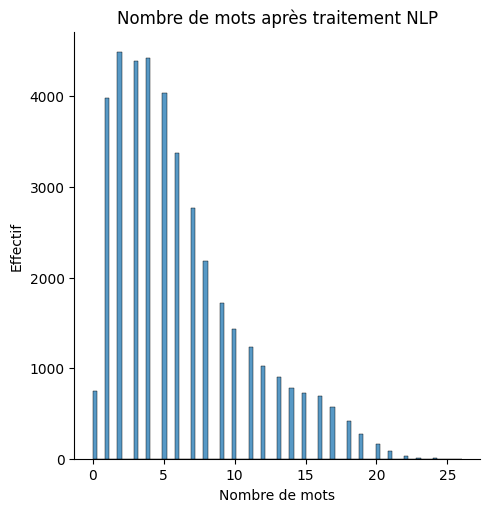

count    40434.000000
mean         6.171242
std          4.542275
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         26.000000
Name: long_coms, dtype: float64


In [72]:
data_prep = cpt_mots(data_prep, "tokenized_comments_join", "Nombre de mots après traitement NLP")

####  Commentaire :
On peut observer après traitement NLP, que la majorité de nos commentaires traitées ont moins de 8 mots (pour 75% des cas). Le nombre de mots maximal est passé de 45 mots à 26 mots après traitement ce qui montre la présence de caractères aberrantes et la présence probable de mots "insensés".

In [73]:
# Observer la présence de commentaire vide
data_prep[data_prep["long_coms"] < 1] # 747 lignes concernées

target tokenized_comments_join  long_coms
56     très satisfait                                  0
64     très satisfait                                  0
107    très satisfait                                  0
205    très satisfait                                  0
294    très satisfait                                  0
...               ...                     ...        ...
40703  très satisfait                                  0
40708  très satisfait                                  0
40727  très satisfait                                  0
40742  très satisfait                                  0
40935       satisfait                                  0

[747 rows x 3 columns]

In [74]:
# Supprimer ceux qui ont une longeur de commentaire de 0 (inutile pour la suite)
data_prep = data_prep[data_prep["long_coms"] > 0]

In [75]:
# Vérification du succès de l'opération
data_prep[data_prep["long_coms"] < 1]

Empty DataFrame
Columns: [target, tokenized_comments_join, long_coms]
Index: []

In [76]:
# Regardons la répartition de la valeur cible après traitement nlp
round(data_prep["target"].value_counts(normalize=True) * 100, 2)

target
très satisfait    64.32
mécontent         21.65
satisfait          8.74
insatisfait        5.29
Name: proportion, dtype: float64

In [77]:
# Regardons ses dimensions
data_prep.shape

(39687, 3)

In [78]:
round(((39687 - 40641)/ 40641) * 100, 2)

-2.35

#### Commentaire :
Avant traitement NLP, nous étions à 40 641 commentaires non-vides. Après traitement NLP, nous sommes arrivés à 39 687 soit 2,35% par rapport au dataframe initiale.

# **3ème partie : segmentation de nos données**

Maintenant que les données sont prêtes, nous allons pouvoir appliquer la réduction des dimensions et créer un modèle de clustering pour identifier facilement nos 4 catégories.

## Importation des librairies pour la modélisation + création fonction utilitaires pour la segmentation

In [79]:
# Chargement des librairies
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn import preprocessing
import time

In [81]:
# Application de l'ACP pour la réduction en dimension de nos données
def TSVD_fct(x, n_components=0.95, start_comp=10, pas_comp = 10):
    """
    But : Appliquer l'ACP pour réduire la dimension de nos données X

    Arguments :
    - x : matrice de données chiffrées
    - n_components : pourcentage d'inertie à dépasser (0.95 par défaut)
    - start_comp : le nombre de composants initiale (10 par défaut)
    - pas_comp : pas du nombre de composants pour l'ACP (10 par défaut)
    
    Retour :
    - x_pca : matrice de données réduites
    """
    print("Dimensions dataset avant réduction PCA : ", x.shape)
    
    for n in range(start_comp, x.shape[1], pas_comp):
        pca = decomposition.TruncatedSVD(n_components=n, random_state=seed)
        x_pca = pca.fit_transform(x)
        print("Pourcentage d'inertie pour "+str(n) + " : "+str(round(pca.explained_variance_ratio_.sum()*100, 2)))
        if pca.explained_variance_ratio_.sum() >= n_components : break
    
    print("Dimensions dataset après réduction PCA : ", x_pca.shape)
    
    return x_pca


In [82]:
# Application de la méthode des k-means
def ARI_fct(x_pca, true_labels, perplexity=30, # Paramètre de tsender
            learning_rate=100, n_iter=2000 # nombre d'itération qu'on fait sur k-means
           ):
    """
    But : Appliquer la méthode des K-Means pour une segmentation de nos données

    Arguments :
    - x_pca : matrice de données (distance)
    - true_labels : les vrais valeurs de la variable cible
    - perplexité : niveau de concentration sur les relations (par défaut : 30)
    - learning_rate : vitesse à laquelle les points sont ajustées (par défaut : 100)
    - n_iter : nombre d'itération qu'on fait sur la méthode TSNE pour la réduction à deux dimensions (par défaut : 2000)

    Retour :
    - ARI : score du modèle en comparant avec les vrais valeurs
    - x_tsne : matrice de distance réduite à deux dimensions (méthode TSNE)
    - model_labels : les labels du modèles

    """

    # Réduction en deux dimensions de la matrice de distance
    time1 = time.time()
    
    tsne = manifold.TSNE(n_components=2,
                        perplexity = perplexity,
                        n_iter = n_iter,
                        init = 'random',
                        learning_rate = learning_rate,
                        random_state=seed)
    
    x_tsne = tsne.fit_transform(x_pca)
    
    # Détermination des clusters à partir des données après tsne
    cls = cluster.KMeans(n_clusters=4, n_init=100, random_state=seed)
    cls.fit(x_tsne)
    
    # Calcul du score ARI
    # Evaluer la séparation entre clusters
    model_labels = cls.labels_
    ARI = np.round(metrics.adjusted_rand_score(true_labels, model_labels), 4)
    
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "\nTime : ", time2)
    
    return ARI, x_tsne, model_labels

In [83]:
def TSNE_visu_fct(x_tsne, true_labels, model_labels):

    """
    But : Fait le visuel graphique entre les vrais valeurs et le modèle donnée.

    Arguments :
    - x_tsne : matrice de distance à deux dimensions
    - true_labels : les vrais valeurs
    - model_labels : les valeurs déduites par le modèle de clustering

    Retour :
    - Deux nuages de dispersions pour comparer les vrais valeurs et les valeurs du modèle
    """        
    fig = plt.figure(figsize=(20, 10))
    
    le = preprocessing.LabelEncoder()
    true_labels_num = le.fit_transform(true_labels)
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(
    x_tsne[:, 0],
    x_tsne[:, 1],
    c = true_labels_num,
    cmap="Set1")
    
    ax.legend(handles=scatter.legend_elements()[0],
             labels = set(true_labels),
             loc="best",
             title="Categories"
             )
    
    plt.title('Représentation des avis par niveau de satisfaction réel')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(x_tsne[:, 0],
                        x_tsne[:, 1], 
                        c=model_labels,
                        cmap="Set1")
    
    ax.legend(handles=scatter.legend_elements()[0],
             labels = set(model_labels),
             loc = "best",
             title = "Clusters")
    
    plt.title("Représentation des avis par clusters")
    

In [84]:
# Récupération des vrais valeurs
true_labels = data_prep.target.tolist()

In [85]:
# Vérification du succès de l'opération
len(true_labels)

39687

## Approche "Bag of Words"

Cette approche permet de créer des vecteurs à partir du texte pour avoir la fréquence de tous les mots distincts présents dans le texte. Cela va nous servir à la suite pour créer notre modèle de segmentation.

### Application de l'approche

In [86]:
# Importation de la fonction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

In [87]:
# Instancions la fonction
cv = CountVectorizer()

# Vectorisons le texte (bag of words)
x = cv.fit_transform(data_prep["tokenized_comments_join"])

In [88]:
# Vérification du succès de l'opération
x.shape

(39687, 6158)

In [89]:
# Regardons les cents premières features
cv.get_feature_names_out()[:100]

array(['abafado', 'abaixar', 'abaixo', 'abandonar', 'abar',
       'abastecimento', 'abaular', 'abc', 'abdominal', 'abel', 'abençoar',
       'abençoe', 'aberto', 'abertura', 'abone', 'abordo', 'aborrecer',
       'aborrecimentar', 'aborrecir', 'abra', 'abraçar', 'abraço', 'abri',
       'abrigar', 'abril', 'abrir', 'abrirar', 'abro', 'absolutamente',
       'absorvente', 'absorver', 'absorvir', 'absurda', 'absurdamente',
       'absurdo', 'abusivo', 'abuso', 'acabamento', 'acabar', 'acaber',
       'acabo', 'acamar', 'acarretar', 'acatar', 'aceitar', 'aceitável',
       'acelerar', 'acender', 'acento', 'acerca', 'acertar', 'acerto',
       'acesor', 'acesso', 'acessível', 'acessório', 'acetinar', 'achar',
       'acharia', 'achegar', 'acháva', 'acidente', 'acima', 'acionar',
       'acolchoar', 'acolhedor', 'acolher', 'acomoda', 'acomodar',
       'acompanhamento', 'acompanhar', 'acompanhei', 'acompanho',
       'acompanháva', 'aconchegante', 'acondicionamento', 'acondicionar',
      

### Création du modèle de segmentation

In [90]:
# Réduire la dimensionalité des données en appliquant l'ACP 
x_pca_bg_words = TSVD_fct(x, # Matrice à reduire
                          0.94, # Pourcentage d'inertie qu'on veut avoir
                          1285, # Valeur initiale pour le nombre de composantes (nb composantes optimisée pour 95%)
                          10) # Pas pour le nombre de composants principales

Dimensions dataset avant réduction PCA :  (39687, 6158)
Pourcentage d'inertie pour 1285 : 95.0
Dimensions dataset après réduction PCA :  (39687, 1285)


In [91]:
# Vérification du succès de l'opération
#x_pca_bg_words

In [92]:
# Calcul du score ARI pour savoir la qualité du modèle et savoir les valeurs du modèle (6 minutes d'exécutions)
ARI, x_tsne_bg_words, model_labels_bg_words = ARI_fct(
    x_pca_bg_words, # Matrice ACP réduite
    true_labels, # Les vrais valeurs  
    perplexity = 10, # Perplexité  (niveau de concentration sur les relations)
    learning_rate = 50, # Vitesse à laquelle les points sont ajustées
    n_iter = 1000
)

# Score de 8.29%
# Très faible

c:\Users\Utilisateur\OneDrive\Documents\SAE_mongo_db_data_mining\envSAE\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0829 
Time :  636.0


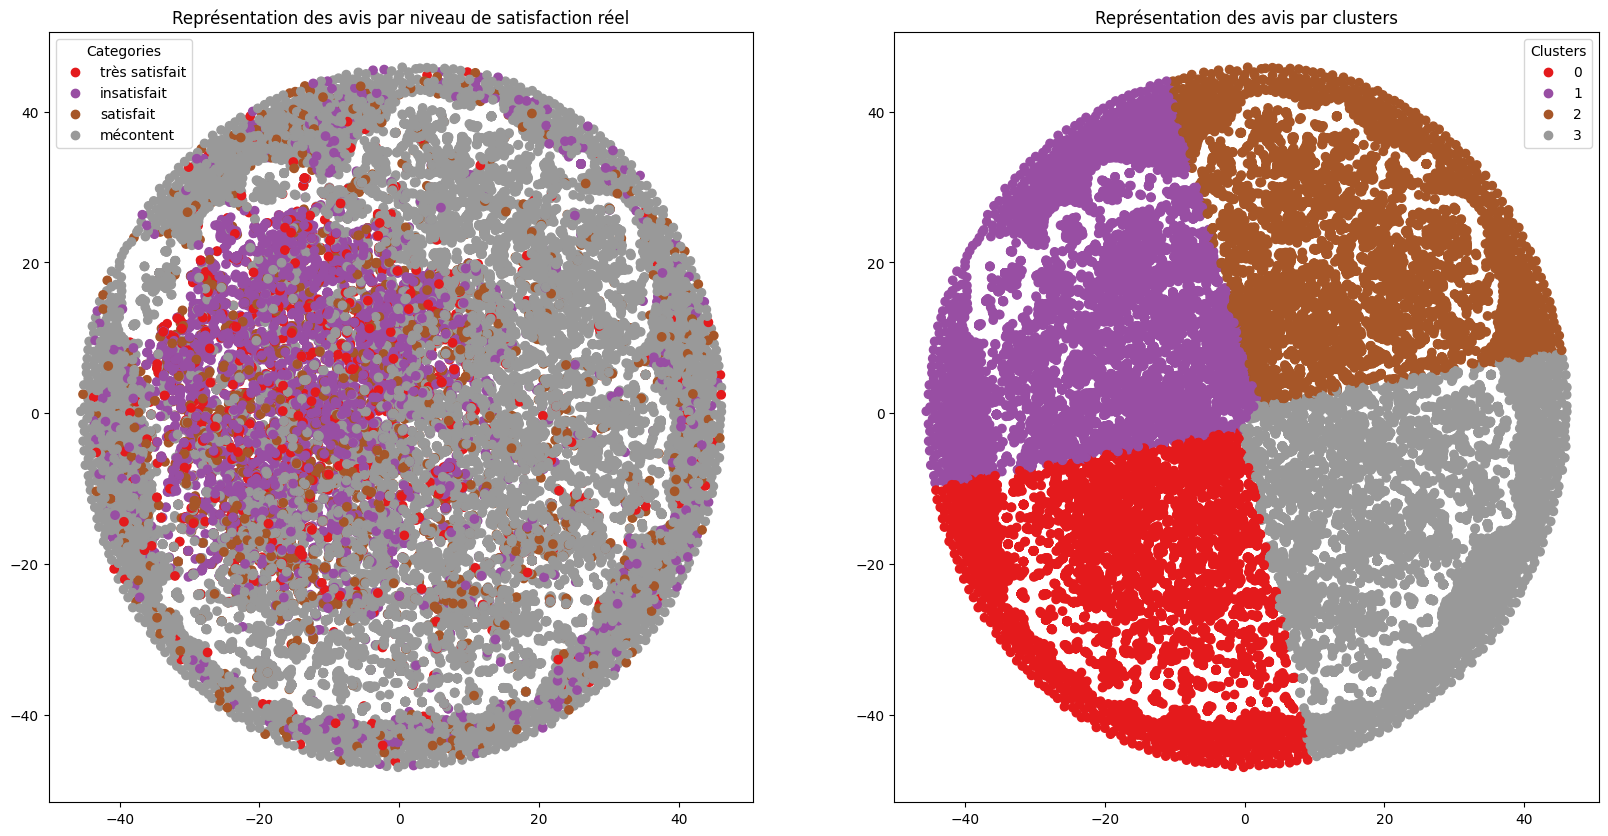

In [93]:
# Visuel graphique
TSNE_visu_fct(
    x_tsne_bg_words, # Matrice de données réduites en deux dimensions
    true_labels, # Les vrais valeurs
    model_labels_bg_words) # Les modalités des labels

#### Commentaire :
On très vite remarquer que le modèle créé ne correspond pas du tout à ce qu'on attends. Le score est de 8,29%  environ sans normalisation montrant le peu de succès de segmenter la satisfaction clientèle. Pour expliquer cela, on a une matrice de très grande dimension qui est éparse car il a beaucoup de présence de 0 ce qui rends la segmentation difficille. Il faudra peut-être dans une amélioration future préparer plus précisément les données notamment au niveau de la lemmatisation. Les points sont très regroupées ce qu'il rends impossible au modèle de différencier très clairement la satisfaction du client.

## Approche TF-IDF

En voyant que le premier modèle ne fait pas son effet sur la première approche, on va utiliser la deuxième approche. TF-IDF se base sur deux métriques qui sont la fréquence du mot (TF) et l'inverse de la fréquence des documents pour chaque terme. 

### Application de l'approche

In [94]:
# Approche TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [95]:
# Calcul de la matrice de distance avec la deuxième approche
tfidf = TfidfVectorizer()

x = tfidf.fit_transform(data_prep["tokenized_comments_join"])

In [96]:
# Vérification du succès de l'opération
x.shape

(39687, 6158)

### Création du modèle de segmentation

In [97]:
# Application de l'ACP
x_pca_tf_idf = TSVD_fct(x, 0.95, 1850, 25)

Dimensions dataset avant réduction PCA :  (39687, 6158)
Pourcentage d'inertie pour 1850 : 95.06
Dimensions dataset après réduction PCA :  (39687, 1850)


In [98]:
# Vérification du succès de l'opération
#x_pca_tf_idf

In [ ]:
# Calcul du score ARI pour savoir la qualité du modèle et savoir les valeurs du modèle
ARI, x_tsne_tf_idf, model_labels_tf_idf = ARI_fct(
    x_pca_tf_idf, # Matrice ACP réduite
    true_labels, # Les vrais valeurs  
    perplexity = 10, # perplexité  (niveau de concentration sur les relations)
    learning_rate=50, # vitesse à laquelle les points sont ajustées
    n_iter = 1000
)

# 5.16 % : score très faible

c:\Users\Utilisateur\OneDrive\Documents\SAE_mongo_db_data_mining\envSAE\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0516 
Time :  678.0


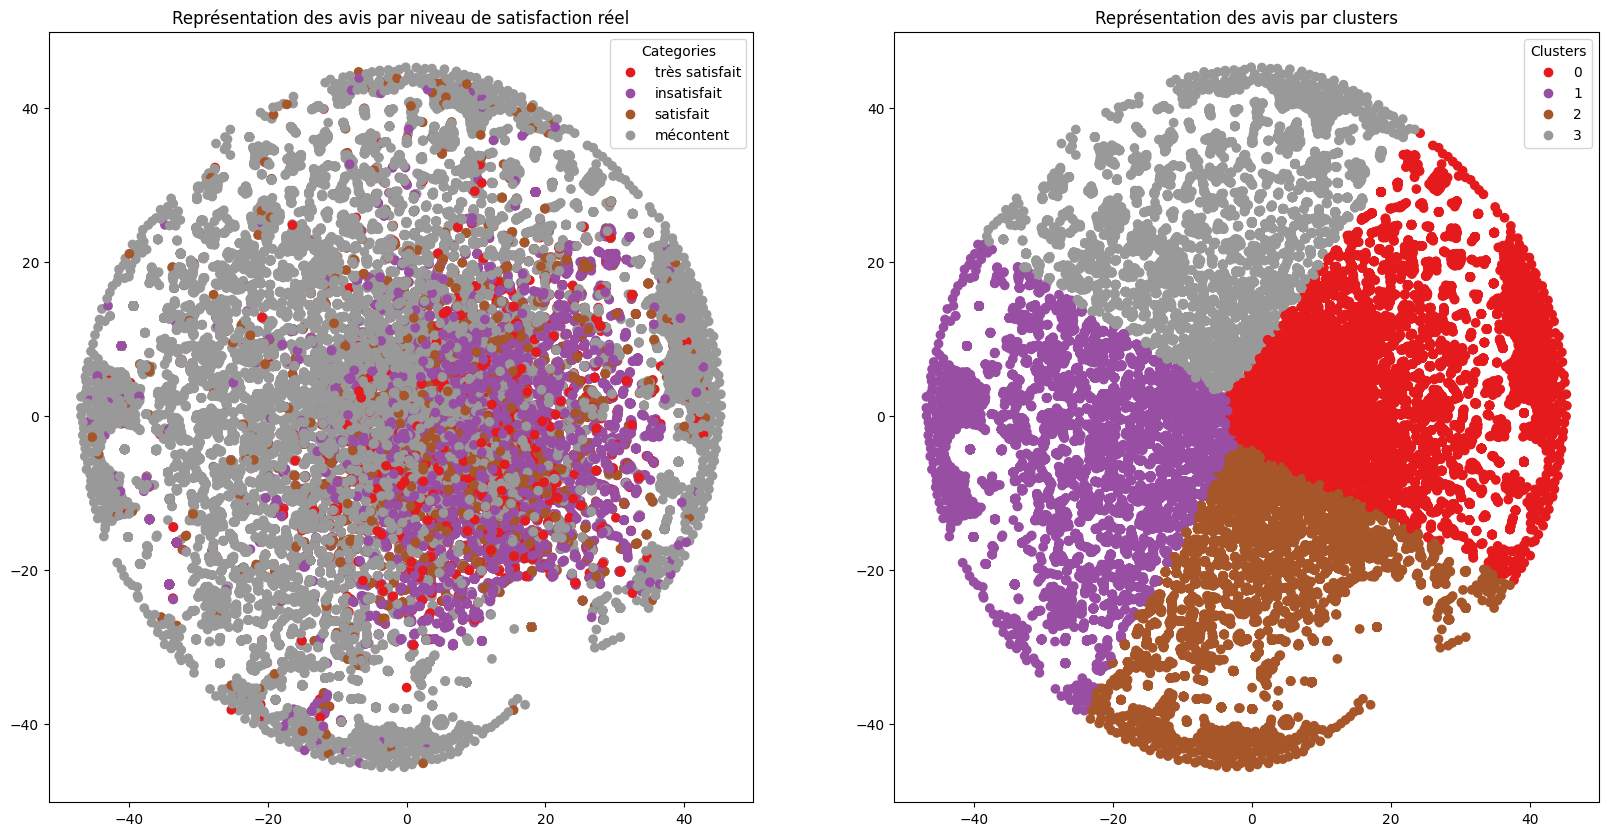

In [100]:
# Visuels graphiques
TSNE_visu_fct(x_tsne_tf_idf, true_labels, model_labels_tf_idf)

#### Commentaire :
Même chose avec la méthode TF-IDF où on a un moins bon score que la précédente approche montrant la difficultée de segmenter ces données. On peut faire la même observation où nos différentes classes sont très mélangées.

# **4ème partie : Deep Learning sur la satisfaction du client à partir de son commentaire**

Dans cette dernière partie, nous allons créer un réseaux de neurones capable de classer la satisfaction du client selon le commentaire qu'il a fait. Cela se fera à travers les librairies scikit-learn et keras pour l'encodage, la création du modèle, l'entraînement et l'évaluation.

## Importation des librairies nécessaires au Deep Learning

In [118]:
# Chargement des librairies
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Architecture du réseaux de neurones
from keras import models
from keras import layers
from sklearn.metrics import roc_curve, auc # Pour la courbe ROC
import tensorflow as tf

In [119]:
# Fixer l'aléatoire
np.random.seed(seed)                   # Fixe la graine NumPy
tf.random.set_seed(seed)               # Fixe la graine TensorFlow

In [120]:
# Création de la fonction utilitaire sur la matrice de confusion 
def cm_model(model, x_test, y_test, le):

    """
    Fonction : création de la matrice de confusion 

    Arguments :
    - model : modèle à utiliser
    - x_test : matrice de données x
    - y_test : vrais valeurs de l'échantillon de test
    - le : l'encodage numérique pour la transformation inverse

    Retour :
    - cm : matrice de confusion
    - Affichage de la matrice de confusion 
    
    """
    # Prédiction de l'échantillon de test
    y_pred = model.predict(x_test)

    # Récupération des modalités selon la probabilité maximum de chaque ligne
    y_pred_class = np.argmax(y_pred, axis=1) # Probabilité maximum de chaque ligne

    # Transformation inverse de l'encodage
    y_pred_class = le.inverse_transform(y_pred_class)

    # Récupérons les vrais valeurs de l'échantillon de test
    y_test_class = le.inverse_transform(y_test)

    # Création de la matrice de confusion
    cm = confusion_matrix(y_test_class, y_pred_class)

    # Visuel graphique de la matrice de confusion
    plt.figure(figsize=(12, 10))
    
    ax = plt.subplot()

    # Création de la matrice de confusion
    sns.heatmap(cm, annot=True, fmt="g", ax=ax)

    ax.set_xlabel("Valeurs prédictes")
    ax.set_ylabel("Vrais valeurs")
    ax.set_title("Matrice de confusion")
    
    ax.xaxis.set_ticklabels(list(le.classes_))
    ax.yaxis.set_ticklabels(list(le.classes_))

    plt.show()

    return cm

In [121]:
def courbe_roc_class(model, x_true, y_true, le):
    """

    Fonction : création de la courbe ROC pour chaque classe.

    Arguments :
    - model : modèle à utiliser
    - x_true : matrice de données X
    - y_true : matrice des vrais valeurs
    - le : l'encodage numérique pour savoir les classes catégoriques

    Retour :
    - Affichage de la courbe ROC 
    
    """


    # Prédiction de l'échantillon de test
    y_pred = model.predict(x_true)

    # Initialisation des variables
    fpr = {}  # False Positive Rates
    tpr = {}  # True Positive Rates
    roc_auc = {}  # AUC

    # Calcul pour chaque classe des taux de vrais/faux positifs et calculer l'AUC
    for i in range(len(le.classes_)):

        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i]) # Calcul des vrais/faux positives
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Tracer les courbes ROC pour chaque classe
    plt.figure(figsize=(10, 7))
    for i in range(len(le.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Classe {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    # Ajouter la diagonale et les détails
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC par classe')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [122]:
# Encodage numérique de nos valeurs cibles
LE = LabelEncoder()
y = LE.fit_transform(data_prep['target'])
print("valeurs transformées pour les cinq premières lignes : ", y[0:10])
print("Les valeurs initiales pour les cinq premières lignes : ", LE.inverse_transform(y[0:10]))
print("Les classes de l'encodage : ", LE.classes_)

valeurs transformées pour les cinq premières lignes :  [3 3 3 3 3 0 1 3 3 3]
Les valeurs initiales pour les cinq premières lignes :  ['très satisfait' 'très satisfait' 'très satisfait' 'très satisfait'
 'très satisfait' 'insatisfait' 'mécontent' 'très satisfait'
 'très satisfait' 'très satisfait']
Les classes de l'encodage :  ['insatisfait' 'mécontent' 'satisfait' 'très satisfait']


## **Approche Bag of Words**

### Partition des données (apprentissage/test)

In [123]:
# Échantillonnage dans le jeu de données BG Words
x_train_bg, x_test_bg, y_train_bg, y_test_bg = train_test_split(x_pca_bg_words, y, test_size = 0.2, random_state=25)

In [124]:
# Création des deux matrices de distances
train_labels = to_categorical(y_train_bg)
test_labels = to_categorical(y_test_bg)

In [125]:
# Regarder la répartition des valeurs cibles entre l'échantillon de test et d'apprentissage
prct_train = round(pd.Series(y_train_bg).value_counts(normalize=True) * 100, 2)
prct_test = round(pd.Series(y_test_bg).value_counts(normalize=True) * 100, 2)
counts_train = pd.Series(y_train_bg).value_counts()
counts_test = pd.Series(y_test_bg).value_counts()

In [126]:
# Regardons côté apprentissage
print(counts_train)
print(prct_train)

3    20376
1     6898
2     2765
0     1710
Name: count, dtype: int64
3    64.18
1    21.73
2     8.71
0     5.39
Name: proportion, dtype: float64


In [127]:
# Regardons côté test
print(counts_test)
print(prct_test)

3    5150
1    1695
2     702
0     391
Name: count, dtype: int64
3    64.88
1    21.35
2     8.84
0     4.93
Name: proportion, dtype: float64


### Normalisation des données 

In [128]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Normalisation

In [129]:
x_train_scaled = scaler.fit_transform(x_train_bg)
x_test_scaled = scaler.transform(x_test_bg)

In [130]:
# Observation de la normalisation
x_train_scaled.shape

(31749, 1285)

In [131]:
# Vérification de l'application
print("Moyenne : ", x_train_scaled.mean()) # Très proche de 0
print("Variance : ", x_train_scaled.var()) # Très proche de 1
# Donc les données sont bien normalisées

Moyenne :  1.3228585034550163e-17
Variance :  1.0000000000000033


In [132]:
# Vérification de l'application
print("Moyenne : ", x_train_bg.mean()) # Très proche de 0
print("Variance : ", x_train_bg.var()) # Proche de 0
# Donc les données sont bien normalisées

Moyenne :  0.0008405224446606251
Variance :  0.005029804466706619


### Création du réseaux de neurones

In [133]:
# Archictecture du réseaux de neurones
network_bg = models.Sequential()
network_bg.add(layers.Dense(50, activation='relu', input_shape=(x_train_bg.shape[1],) )) # 50 neurones, fct_act = relu
network_bg.add(layers.Dense(30, activation='relu')) # 30 neurones, fct_act = relu
network_bg.add(layers.Dense(20, activation='relu')) # 20 neurones, fct_act = relu
network_bg.add(layers.Dense(4, activation='softmax')) # output 4 classes, activation : softmax

c:\Users\Utilisateur\OneDrive\Documents\SAE_mongo_db_data_mining\envSAE\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [134]:
# Définition de l'optimiser, de la fct de perte et de la métrique
network_bg.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [135]:
network_bg.fit(x_train_bg, # La matrice de données d'entraînement 
               train_labels, # Les labels de l'échantillon d'entraînement
               epochs=3, # Le nombre de fois qu'on passe l'ensemble des données entièrements
               batch_size=32) # Nombre d'échantillons traitées avant chaque mise à jour

Epoch 1/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7070 - loss: 0.7997
Epoch 2/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8012 - loss: 0.5700
Epoch 3/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8175 - loss: 0.5293


### Qualité du modèle (matrice de confusion + courbe ROC)

In [136]:
# Évaluation du modèle sur l'échantillon de test
test_loss, test_acc = network_bg.evaluate(x_test_bg, test_labels)
print('test_acc : ', test_acc, "test_loss : ", test_loss) # 78-9 % (trois couches)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8005 - loss: 0.5930
test_acc :  0.7898715138435364 test_loss :  0.6140587329864502


249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


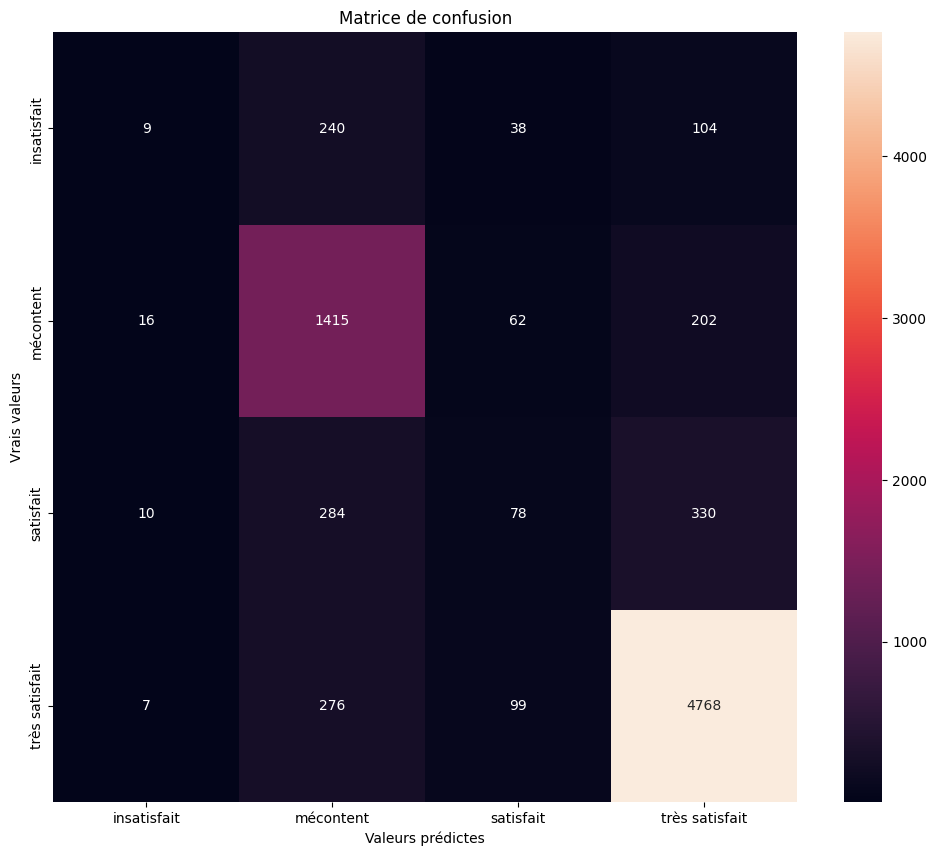

In [137]:
# Création de la matrice de confusion
cm_bg = cm_model(network_bg, x_test_bg, y_test_bg, LE)

In [138]:
# Pour observer la proportion
pd.Series(y_test_bg).value_counts()

3    5150
1    1695
2     702
0     391
Name: count, dtype: int64

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


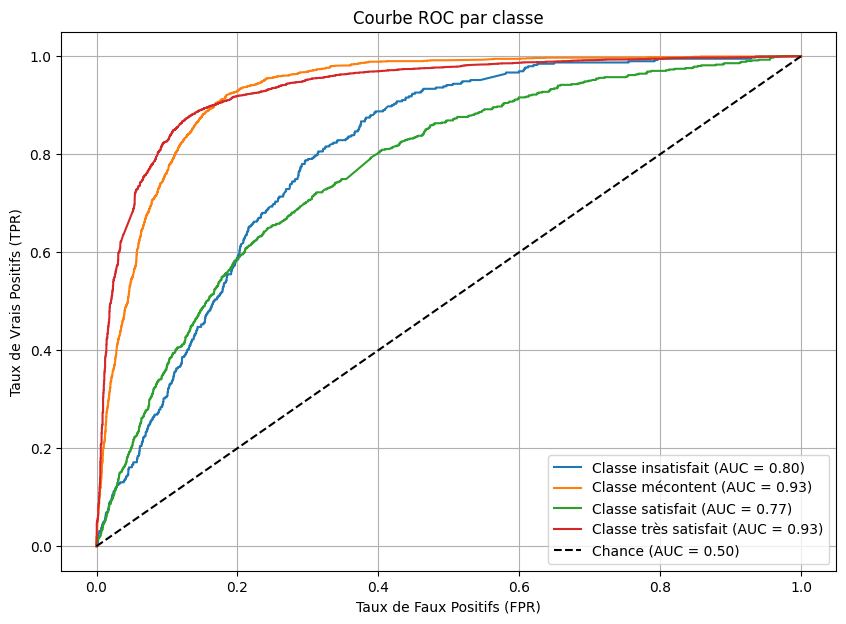

In [139]:
# Visuel graphique de la courbe ROC
courbe_roc_class(network_bg, x_test_bg, test_labels, LE)

#### Commentaire :
On peut observer fait plutôt un bon score dans les deux parties ne montrant aucunement le signe d'un sous-apprentissage ou de sur-apprentissage. Le score pour l'échantillon d'apprentissage est de 81% et pour le test de 79%. Le modèle donc prédit bien nos différentes classes. Cependant, ces 4 classes ne sont pas du tout équilibrées en terme de proportion ce qui nuit à l'adaption du modèle à la réalité. Pourquoi ? En observant notre matrice de confusion, on observe qu'il prédit les deux classes qui sont "mécontent" et "très satisfait" tandis que pour les deux autres classes, il prédit beaucoup moins bien et n'arrive pas à bien prédire pour ces deux classes (0 de prédictions correctes pour la classe "insatisfait").

### Pour le cas avec normalisation

In [140]:
network_bg.fit(x_train_scaled, # La matrice de données d'entraînement 
               train_labels, # Les labels de l'échantillon d'entraînement
               epochs=3, # Le nombre de fois qu'on passe l'ensemble des données entièrements
               batch_size=32, # Nombre d'échantillons traitées avant chaque mise à jour
               ) 

Epoch 1/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7484 - loss: 1.2580
Epoch 2/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8255 - loss: 0.5024
Epoch 3/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8516 - loss: 0.4264


In [141]:
# Évaluation du modèle sur l'échantillon de test
test_loss, test_acc = network_bg.evaluate(x_test_scaled, test_labels)
print('test_acc : ', test_acc, "test_loss : ", test_loss)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7757 - loss: 0.8958
test_acc :  0.7620307207107544 test_loss :  0.9262037873268127


249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


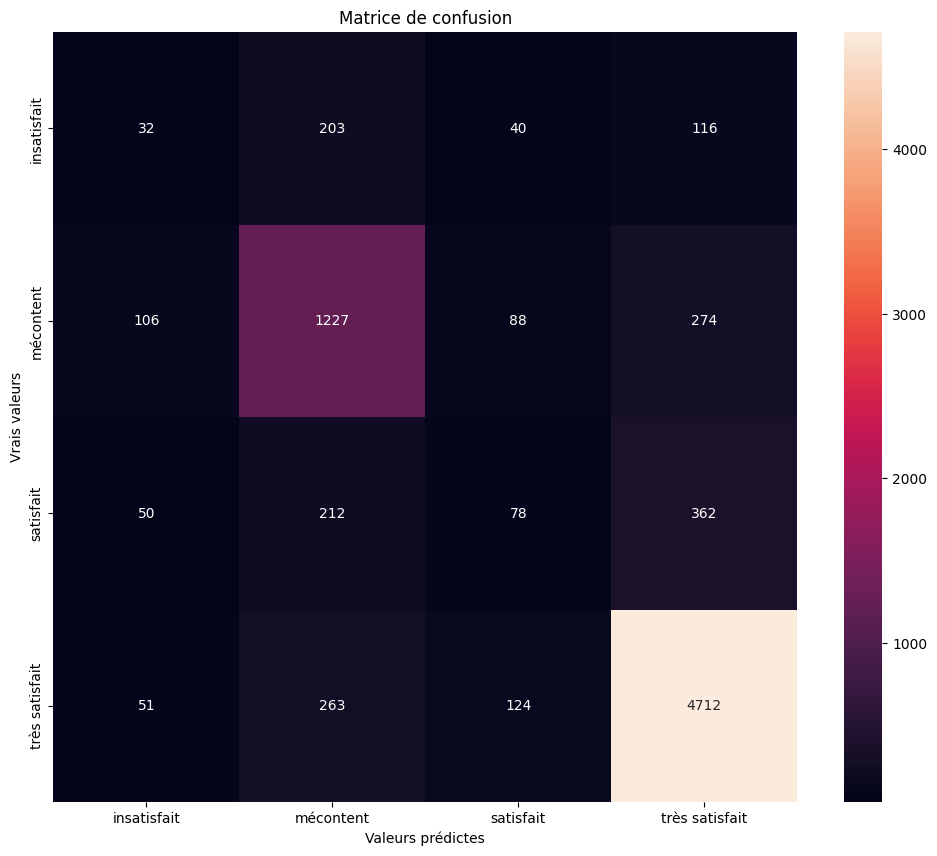

In [142]:
# Création de la matrice de confusion
cm_bg = cm_model(network_bg, x_test_scaled, y_test_bg, LE)

In [143]:
# Pour observer la proportion
pd.Series(y_test_bg).value_counts()

3    5150
1    1695
2     702
0     391
Name: count, dtype: int64

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


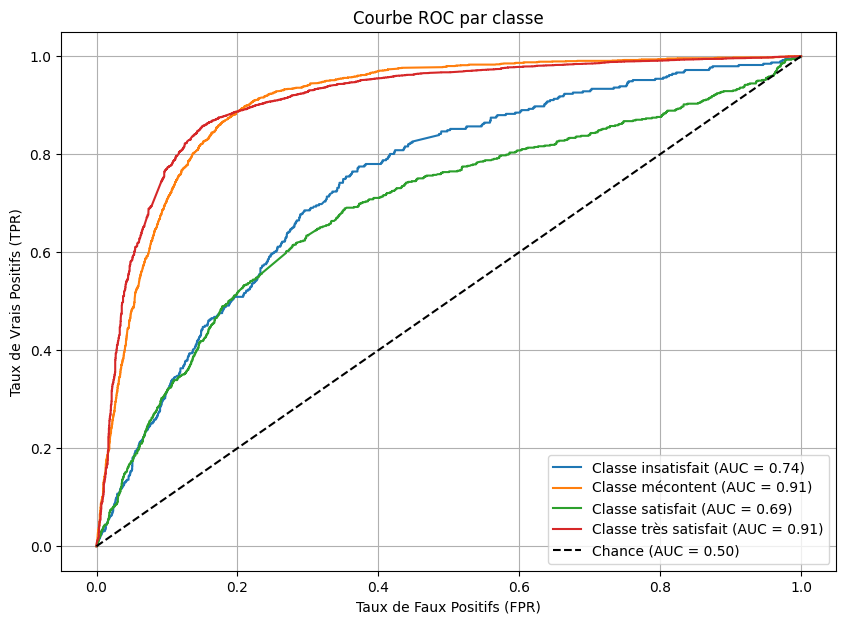

In [144]:
# Visuel graphique de la courbe ROC
courbe_roc_class(network_bg, x_test_scaled, test_labels, LE)

#### Commentaire :
Avec la normalisation sur nos données, le modèle perds en performance mais arrive à mieux prédire les deux classes minoritaires. On a par contre une mesure de perte de 0,86 sur les données normalisées ce qui n'est pas négligeable et montre que le modèle peut faire des erreurs significatives.

## **Approche TF-IDF**

### Partition de nos données

In [145]:
# Application de la partition
x_train_tf_idf, x_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(x_pca_tf_idf, y, test_size = 0.2, random_state=25)

In [146]:
# Matrices à créer 
train_labels = to_categorical(y_train_tf_idf)
test_labels = to_categorical(y_test_tf_idf)

In [147]:
# Regarder la répartition des valeurs cibles entre l'échantillon de test et d'apprentissage
prct_train = round(pd.Series(y_train_tf_idf).value_counts(normalize=True) * 100, 2)
prct_test = round(pd.Series(y_test_tf_idf).value_counts(normalize=True) * 100, 2)
counts_train = pd.Series(y_train_tf_idf).value_counts()
counts_test = pd.Series(y_test_tf_idf).value_counts()

In [148]:
# Regardons côté apprentissage
print(counts_train)
print(prct_train)

3    20376
1     6898
2     2765
0     1710
Name: count, dtype: int64
3    64.18
1    21.73
2     8.71
0     5.39
Name: proportion, dtype: float64


In [149]:
# Regardons côté test
print(counts_test)
print(prct_test)

3    5150
1    1695
2     702
0     391
Name: count, dtype: int64
3    64.88
1    21.35
2     8.84
0     4.93
Name: proportion, dtype: float64


### Normalisation des données

In [150]:
# Normalisation
x_train_tf_idf_scaled = scaler.fit_transform(x_train_tf_idf)
x_test_tf_idf_scaled = scaler.transform(x_test_tf_idf)

In [151]:
# Vérification de l'application
print("Moyenne : ", x_train_tf_idf.mean()) # Très proche de 0
print("Variance : ", x_test_tf_idf.var()) # Très proche de 1
# Donc les données sont bien normalisées

Moyenne :  0.0001550071958222678
Variance :  0.0005144807984779303


In [152]:
# Vérification de l'application
print("Moyenne : ", x_train_tf_idf_scaled.mean()) # Très proche de 0
print("Variance : ", x_train_tf_idf_scaled.var()) # Proche de 0
# Donc les données sont bien normalisées

Moyenne :  -3.242318149853148e-18
Variance :  0.9999999999999988


### Création de notre réseaux de neurones

In [153]:
# Archictecture du réseaux de neurones
network_idf = models.Sequential()
network_idf.add(layers.Dense(50, activation='relu', input_shape=(x_test_tf_idf.shape[1],) )) # 50 neurones, fct_act = relu
network_idf.add(layers.Dense(30, activation='relu')) # 30 neurones, fct_act = relu
network_idf.add(layers.Dense(4, activation='softmax')) # output 4 classes, activation : softmax

c:\Users\Utilisateur\OneDrive\Documents\SAE_mongo_db_data_mining\envSAE\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [154]:
# Définition de l'optimiser
network_idf.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [155]:
# Entraînement du modèle
network_idf.fit(x_train_tf_idf, train_labels, epochs=3, batch_size=32)

Epoch 1/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.7141 - loss: 0.8092
Epoch 2/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7964 - loss: 0.5741
Epoch 3/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8061 - loss: 0.5493


### Évaluation de notre modèle

In [156]:
# Évaluation du modèle sur l'échantillon de test
test_loss, test_acc = network_idf.evaluate(x_test_tf_idf, test_labels)
print('test_acc : ', test_acc, "test_loss : ", test_loss)

249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8021 - loss: 0.5763
test_acc :  0.791887104511261 test_loss :  0.5942632555961609


In [157]:
# Création de la matrice de confusion
cm_bg = cm_model(network_idf, x_test_tf_idf, y_test_tf_idf, LE)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
pd.Series(test_labels).value_counts()

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


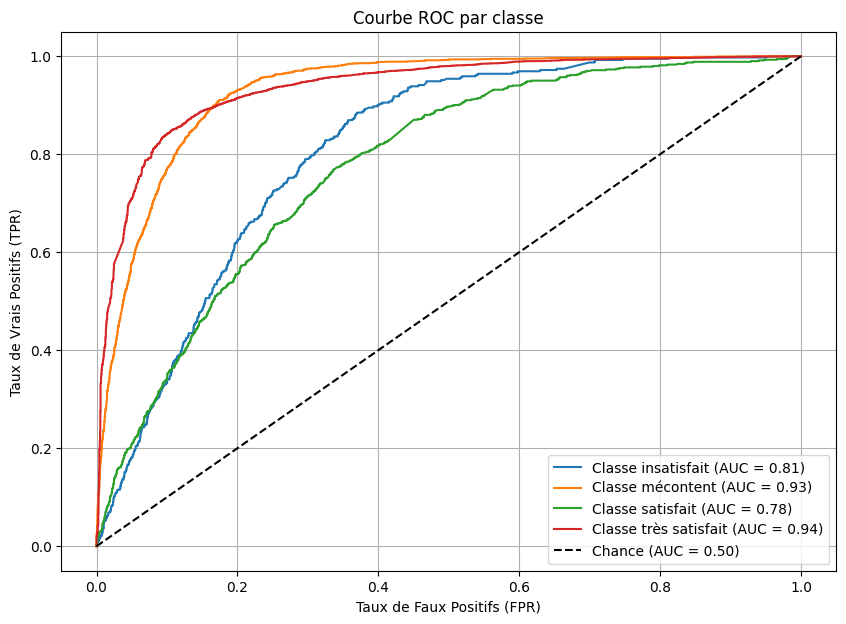

In [158]:
courbe_roc_class(network_idf, x_test_tf_idf, test_labels, LE)

#### Commentaire :
Le modèle avec la feature TF-IDF nous montre deux choses. Première chose, on remarque qu'il fait un meilleur score sur l'échantillon de test que dans la première feature. Deuxième chose, la perte du modèle est moins importante avec la deuxième feature que la première ce qui montre que le modèle peut-être plus robuste à partir du deuxième feature. On retrouve par contre les mêmes soucis qu'avec la première feature où il prédit assez bien nos deux classes majoritaires (très satisfait et mécontent) mais très peu sur les deux classes minoritaires.

### Pour le cas avec la normalisation

In [159]:
network_idf.fit(x_train_tf_idf_scaled, # La matrice de données d'entraînement 
               train_labels, # Les labels de l'échantillon d'entraînement
               epochs=3, # Le nombre de fois qu'on passe l'ensemble des données entièrements
               batch_size=32) # Nombre d'échantillons traitées avant chaque mise à jour

Epoch 1/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7445 - loss: 2.4780
Epoch 2/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8129 - loss: 0.5468
Epoch 3/3
993/993 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8464 - loss: 0.4540


In [160]:
# Évaluation du modèle sur l'échantillon de test
test_loss, test_acc = network_idf.evaluate(x_test_tf_idf_scaled, test_labels)
print('test_acc : ', test_acc, 'test_lost : ', test_loss)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7676 - loss: 0.9444
test_acc :  0.7547240853309631 test_lost :  0.9813739061355591


In [161]:
# Création de la matrice de confusion
cm_bg = cm_model(network_idf, x_test_tf_idf_scaled, y_test_bg, LE)

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [162]:
# Pour observer la proportion
pd.Series(y_test_bg).value_counts()

3    5150
1    1695
2     702
0     391
Name: count, dtype: int64

In [ ]:
# Visuel graphique de la courbe ROC
courbe_roc_class(network_idf, x_test_tf_idf_scaled, test_labels, LE)

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


: 

#### Commentaire :
La normalisation avec TF-IDF nous montre une performance du modèle moins bonne en générale dans toutes les classes. Cela engendre que nous devons pas les normaliser quand on utilise cette approche.